In [1]:
import sys
sys.path.append('..')
from tool import *
from preprocess.DDRF import resample_wb_fraction 
from scipy import stats
import numpy as np
def t_test(a,b):
    if len(a.shape)==1:
        a=a.reshape((1,-1))
    if len(b.shape)==1:
        b=b.reshape((1,-1))
    def t_test_single(a_single,b_single):
        r=stats.ttest_ind(a_single, b_single)
        # return [r.__getattribute__("statistic"),r.__getattribute__("pvalue")]
        return [(r.__getattribute__("statistic")>0).astype(np.int8),(r.__getattribute__("pvalue")<0.05).astype(np.int8)]
    k=[t_test_single(a[i],b[i]) for i in range(a.shape[0])]
    k2=[k[i][0] for i in range(len(k))]
    k3=[k[i][1] for i in range(len(k))]
    return [k2,k3]

In [7]:
from tool import *
mt=[]
for month in range(1,13):
    now=datetime.datetime.strptime(f'2001-{month}-1', '%Y-%m-%d')
    month_time=(now+relativedelta(months=1)-now).total_seconds()
    mt.append(month_time)
mt=np.array(mt)


def month_fill(data,mask):
    data_mean=np.nanmean(data,axis=0)
    for i in range(12):
        data[i][mask[i]]=data_mean[mask[i]]
    return data
from tool import *
stat=torch.load(f'/data/hk/albedo/stat_sw-mean_sza-70_band-shortwave_kernel2.pth')
_,sza_L=torch.load(root_path+'sza_and_szaL.pth')


albedo_all=np.zeros((12,20,18,180,360)).astype(np.float32)
area_all=np.zeros((12,20,18,180,360)).astype(np.float32)
mask=np.zeros((12,20,18,180,360))

for y in range(2001,2021):
    for m in range(1,13):
        albedo_all[m-1,y-2001]=stat[f'{y}-{m}-albedo']
        area_all[m-1,y-2001]=stat[f'{y}-{m}-typearea']
        mask[m-1,y-2001]=np.expand_dims(sza_L[y-2001,m-1],0).repeat(18,axis=0)
# albedo_all=month_fill(albedo_all,mask>=1)
albedo_all[albedo_all==0]=np.nan
albedo_all[mask>=1]=np.nan
area_all=month_fill(area_all,mask>=1)
albedo_all=month_fill(albedo_all,mask>=1)


In [8]:
def get_sequence_map(mode):
    def filter_mode(data,mode):
        if mode=='snowfree':
            data[:,:,:,-1,:]=0
            data[:,:,:,:,-1]=0
        elif mode=='all':
            pass
        elif mode=='snow':
            data[:,:,:,:-1,:-1]=0
        elif mode=='conversion':
            data[:,:,:,-1,:]=0
            data[:,:,:,:,-1]=0
            for i in range(18):
                data[:,:,:,i,i]=0       
        elif mode=='non_conversion':
            mask_filter=np.zeros((18,18))
            for i in range(17):
                mask_filter[i,i]=1
            data=data*(mask_filter.reshape((1,1,1,18,18)))
        else:
            raise('ERROR MODE')
        return data
            
    data_m=torch.load(f'/data/hk/albedo/confuse_matrix/confuse_matrix_2020.pth')
    mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
    data_m[mask_t>=1]=np.nan
    data_m=month_fill(data_m,mask_t>=1)
    if mode in ['snow','conversion','non_conversion']:
        data_m2=data_m.copy()
    data_m=filter_mode(data_m,mode)
    z=albedo_all[:,0].transpose((0,2,3,1)).reshape((12,180,360,18,1))*data_m
    z[np.isnan(z)]=0
    z=z*(mt.reshape(12,1,1,1,1)/365/24/3600)
    z=z.transpose((1,2,3,4,0))
    for i in range(3):
        z=np.nansum(z,axis=-1)
        
    if mode in ['snow','conversion','non_conversion']:
        data_m=data_m2
    data_m=np.nanmean(data_m,axis=0)
    data_m=np.nansum(data_m,axis=-1)
    data_m=np.nansum(data_m,axis=-1)
    kkk=[z/data_m]


    for y in tqdm(range(2002,2021)):
        data_m=torch.load(f'/data/hk/albedo/confuse_matrix/confuse_matrix_{y}.pth')
        mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
        data_m[mask_t>=1]=np.nan
        data_m=month_fill(data_m,mask_t>=1)
        if mode in ['snow','conversion','non_conversion']:
            data_m2=data_m.copy()
        data_m=filter_mode(data_m,mode)
        z=albedo_all[:,y-2001].transpose((0,2,3,1)).reshape((12,180,360,1,18))*data_m
        z[np.isnan(z)]=0
        z=z*(mt.reshape(12,1,1,1,1)/365/24/3600)
        z=z.transpose((1,2,3,4,0))
        for i in range(3):
            z=np.nansum(z,axis=-1)
            
        if mode in ['snow','conversion','non_conversion']:
            data_m=data_m2
        data_m=np.nanmean(data_m,axis=0)
        data_m=np.nansum(data_m,axis=-1)
        data_m=np.nansum(data_m,axis=-1)
        kkk+=[z/data_m]
    return kkk

# np.nansum(z[:,24:90-23])/np.nansum(np.nanmean(data_m[:,24:90-23],axis=0))

100%|██████████| 19/19 [02:11<00:00,  6.93s/it]


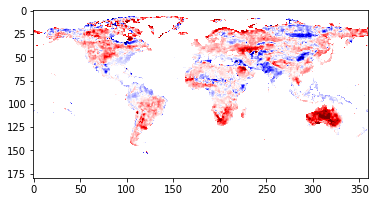

In [9]:
kkk_snowfree=get_sequence_map('snowfree')
plt.imshow(kkk_snowfree[-1]-kkk_snowfree[0],vmax=0.05,vmin=-0.05,cmap='seismic')
plt.show()

100%|██████████| 19/19 [02:21<00:00,  7.47s/it]


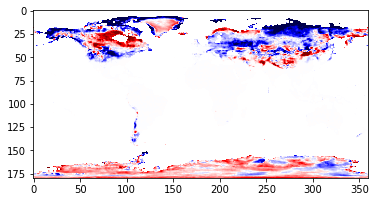

In [10]:
kkk_snow=get_sequence_map('snow')
plt.imshow(kkk_snow[-1]-kkk_snow[0],vmax=0.05,vmin=-0.05,cmap='seismic')
plt.show()

100%|██████████| 19/19 [02:26<00:00,  7.69s/it]


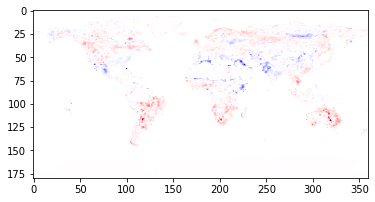

In [11]:
kkk_conversion=get_sequence_map('conversion')
plt.imshow(kkk_conversion[-1]-kkk_conversion[0],vmax=0.05,vmin=-0.05,cmap='seismic')
plt.show()

100%|██████████| 19/19 [02:40<00:00,  8.46s/it]


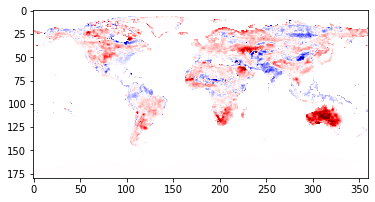

In [12]:
kkk_non_conversion=get_sequence_map('non_conversion')
plt.imshow(kkk_non_conversion[-1]-kkk_non_conversion[0],vmax=0.05,vmin=-0.05,cmap='seismic')
plt.show()

100%|██████████| 19/19 [01:59<00:00,  6.27s/it]


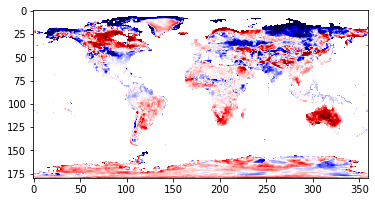

In [13]:
kkk_all=get_sequence_map('all')
plt.imshow(kkk_all[-1]-kkk_all[0],vmax=0.05,vmin=-0.05,cmap='seismic')
plt.show()

In [14]:
def rm_nan(data):
    data[np.isnan(data)]=0
    return data
tif_save(rm_nan(kkk_snowfree[-1]-kkk_snowfree[0]),'../data/snow-free_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save(rm_nan(kkk_snow[-1]-kkk_snow[0]),'../data/snow_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save(rm_nan(kkk_conversion[-1]-kkk_conversion[0]),'../data/conversion_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save(rm_nan(kkk_non_conversion[-1]-kkk_non_conversion[0]),'../data/non-conversion_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save(rm_nan(kkk_all[-1]-kkk_all[0]),'../data/all_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')

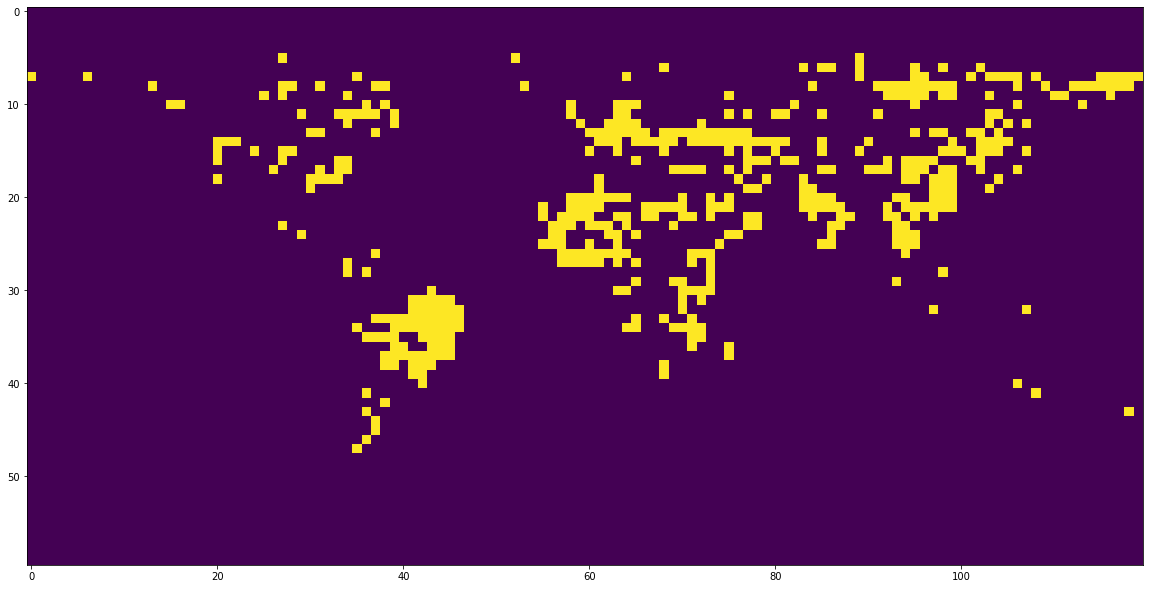

In [15]:
zz=np.stack(kkk_snowfree)
zz_a2=np.stack(zz[:10]).reshape((10,60,-1,360)).reshape((10,60,3,120,-1)).transpose((0,1,3,2,4)).reshape((10,60,120,-1))
zz_a2=np.mean(zz_a2,axis=-1).reshape(10,-1).transpose((1,0))
zz_b2=np.stack(zz[10:]).reshape((10,60,-1,360)).reshape((10,60,3,120,-1)).transpose((0,1,3,2,4)).reshape((10,60,120,-1))
zz_b2=np.mean(zz_b2,axis=-1).reshape(10,-1).transpose((1,0))
t2,p2=t_test(zz_a2,zz_b2)
t_array2=np.array(t2).reshape(60,120)
p_array2=np.array(p2).reshape(60,120)
plt.figure(figsize=(20,30))
plt.imshow(p_array2)
plt.show()

In [16]:
lat=np.array([88.5-3*i for i in range(60)]).reshape((60,1))*np.ones((1,120))
lon=np.array([-178.5+3*i for i in range(120)]).reshape((1,120))*np.ones((60,1))
lat[p_array2==0]=0
lon[p_array2==0]=0
lat=list(lat.reshape((-1,1)))
lon=list(lon.reshape((-1,1)))
coords=[[lat[i],lon[i]] for i in range(len(lat)) if lat[i]!=0]
from shapely import geometry
coords_geo=[geometry.Point(i[1],i[0]) for i in coords]
gpdd=gpd.GeoDataFrame.from_dict({'id':list(range(len(coords_geo))),'geometry':coords_geo})
gpdd=gpdd.set_crs(4326)
gpdd.to_file('../data/significant.shp')

In [2]:
from tool import *

def get_RF_map(mode):
    def filter_mode(data,mode):
        if mode=='snowfree':
            data[:,:,:,-1,:]=0
            data[:,:,:,:,-1]=0
        elif mode=='all':
            pass
        elif mode=='snow':
            data[:,:,:,:-1,:-1]=0
        elif mode=='conversion':
            data[:,:,:,-1,:]=0
            data[:,:,:,:,-1]=0
            for i in range(18):
                data[:,:,:,i,i]=0       
        elif mode=='non_conversion':
            mask_filter=np.zeros((18,18))
            for i in range(17):
                mask_filter[i,i]=1
            data=data*(mask_filter.reshape((1,1,1,18,18)))
        else:
            raise('ERROR MODE')
        return data
    mt=[]
    for month in range(1,13):
        now=datetime.datetime.strptime(f'2001-{month}-1', '%Y-%m-%d')
        month_time=(now+relativedelta(months=1)-now).total_seconds()
        mt.append(month_time)
    mt=np.array(mt)
    stat=torch.load(f'/data/hk/albedo/stat_sw-mean_sza-85_band-shortwave_kernel2.pth')
    _,sza_L=torch.load(root_path+'sza_and_szaL.pth')


    energy_all=np.zeros((12,20,18,180,360)).astype(np.float32)
    area_all=np.zeros((12,20,18,180,360)).astype(np.float32)
    mask=np.zeros((12,20,18,180,360))

    for y in range(2001,2021):
        for m in range(1,13):
            energy_all[m-1,y-2001]=stat[f'{y}-{m}-energy']
            area_all[m-1,y-2001]=stat[f'{y}-{m}-typearea']
            mask[m-1,y-2001]=np.expand_dims(sza_L[y-2001,m-1],0).repeat(18,axis=0)
    # albedo_all=month_fill(albedo_all,mask>=1)
    energy_all[np.isnan(energy_all)]=0
    energy_all[mask>=2]=0
    energy_all=energy_all*mt.reshape((12,1,1,1,1))
    area_all[np.isnan(area_all)]=0
    area_all[mask>=2]=0

    data_m=torch.load('/data/hk/albedo/confuse_matrix/confuse_matrix_2020.pth')

    mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
    data_m[mask_t>=2]=np.nan
    data_m=month_fill(data_m,mask_t>=2)
    data_y=np.nanmean(data_m,axis=0)
    transf=np.nansum(data_y,axis=0)
    transf=np.nansum(transf,axis=0)
    dif_al=[]
    for m in range(12):
        exp1_2020=np.expand_dims(energy_all[m,-1]/area_all[m,-1],0).repeat(18,axis=0)
        exp0_2001=np.expand_dims(energy_all[m,0]/area_all[m,0],1).repeat(18,axis=1)
        dif_al_m=(exp1_2020-exp0_2001).transpose((2,3,0,1))*data_m[m]
        dif_al.append(dif_al_m)
    dif_al=np.stack(dif_al)
    data_y_all=np.nansum(data_y,axis=-1)
    data_y_all=np.nansum(data_y_all,axis=-1)

    dif_al_y=dif_al/365/24/3600/1e6
    dif_al_y=filter_mode(dif_al_y,mode)
    dif_al_y=np.nansum(dif_al_y,axis=0)
    dif_al_y=np.nansum(dif_al_y,axis=-1)
    dif_al_y=np.nansum(dif_al_y,axis=-1)
    output=dif_al_y/data_y_all
    return output
    





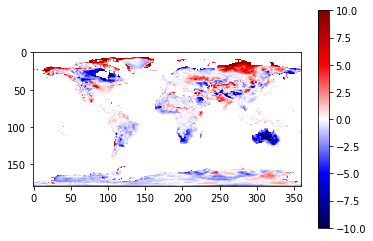

In [3]:
dif_all=get_RF_map('all')
plt.imshow(dif_all,vmax=10,vmin=-10,cmap='seismic')
plt.colorbar()
plt.show()

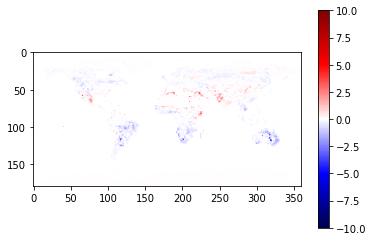

In [4]:
dif_conversion=get_RF_map('conversion')
plt.imshow(dif_conversion,vmax=10,vmin=-10,cmap='seismic')
plt.colorbar()
plt.show()

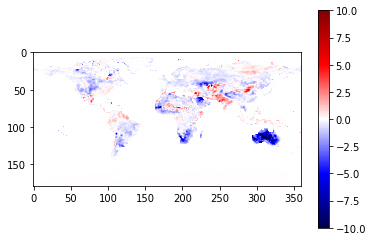

In [5]:
dif_non_conversion=get_RF_map('non_conversion')
plt.imshow(dif_non_conversion,vmax=10,vmin=-10,cmap='seismic')
plt.colorbar()
plt.show()

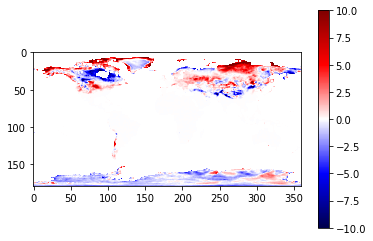

In [6]:
dif_snow=get_RF_map('snow')
plt.imshow(dif_snow,vmax=10,vmin=-10,cmap='seismic')
plt.colorbar()
plt.show()

In [7]:
def rm_nan(data):
    data[np.isnan(data)]=0
    return data
tif_save(rm_nan(dif_snow),'../data/RF_snow_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save(rm_nan(dif_conversion),'../data/RF_conversion_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save(rm_nan(dif_non_conversion),'../data/RF_non-conversion_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')
tif_save(rm_nan(dif_all),'../data/RF_all_1degree.tif',(-179.5,1,0,89.5,0,-1),p='4326')

In [9]:
dif_all.max()

43.19144578295431